In [1]:
import numpy as np
import os
import csv
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import multiprocessing as mp
from oucorr import calcCorr, calcSingleCorr
import itertools
import glob


SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

SEED = 350107321 # from random.org
np.random.seed(SEED)

print(plt.style.available)
plt.style.use('seaborn-white')

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [5]:
filenames_bhb = glob.glob("results/connectivity/*bhb*run-1*")
filenames_glc = glob.glob("results/connectivity/*glc*run-1*")
filenames = filenames_bhb + filenames_glc
filenames

['results/connectivity/sub-052_ses-bhb_task-rest_run-1_CdCB.npz',
 'results/connectivity/sub-047_ses-bhb_task-task_run-1_CdCB.npz',
 'results/connectivity/sub-029_ses-bhb_task-task_run-1_CdCB.npz',
 'results/connectivity/sub-093_ses-bhb_task-task_run-1_CdCB.npz',
 'results/connectivity/sub-082_ses-bhb_task-rest_run-1_CdCB.npz',
 'results/connectivity/sub-010_ses-bhb_task-rest_run-1_CdCB.npz',
 'results/connectivity/sub-056_ses-bhb_task-rest_run-1_CdCB.npz',
 'results/connectivity/sub-041_ses-bhb_task-rest_run-1_CdCB.npz',
 'results/connectivity/sub-084_ses-bhb_task-task_run-1_CdCB.npz',
 'results/connectivity/sub-054_ses-bhb_task-task_run-1_CdCB.npz',
 'results/connectivity/sub-080_ses-bhb_task-task_run-1_CdCB.npz',
 'results/connectivity/sub-091_ses-bhb_task-rest_run-1_CdCB.npz',
 'results/connectivity/sub-045_ses-bhb_task-rest_run-1_CdCB.npz',
 'results/connectivity/sub-064_ses-bhb_task-task_run-1_CdCB.npz',
 'results/connectivity/sub-048_ses-bhb_task-task_run-1_CdCB.npz',
 'results/

In [15]:
# 720 = 24x30 so splitting it up into chuncks of 30 is a good idea
WINDOW_LENGTH = 30
REGIONS = 498

np.tri(REGIONS,k=-1)

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 1., 0., 0.],
       [1., 1., 1., ..., 1., 1., 0.]])

In [18]:
# make one big list
C_list = []
dC_list = []
B_list = []
for f in filenames:
    data = np.load(f)
    C = data['C']
    dC = data['dC']
    B = data['B']
    if np.isnan(np.mean(C)) or np.isnan(np.mean(dC))  or np.isnan(np.mean(B)):
        continue
    Clower = (C * np.tri(REGIONS,k=-1)).flatten()
    Clower = Clower[Clower!=0.]
    dClower = (dC * np.tri(REGIONS,k=-1)).flatten()
    dClower = dClower[dClower!=0.]
    Blower = (B * np.tri(REGIONS,k=-1)).flatten()
    Blower = Blower[Blower!=0.]
    
    C_list.append(Clower)
    dC_list.append(dClower)
    B_list.append(Blower)
    
C_all = np.array(C_list)
dC_all = np.array(dC_list)
B_all = np.array(B_list)
print(C_all.shape,dC_all.shape,B_all.shape)

(79, 123753) (79, 123753) (79, 123753)


119.86369618810424
-23.45793764056911


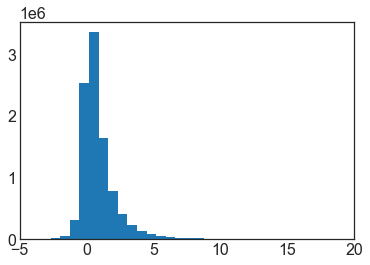

In [24]:
plt.hist(C_all.flatten(), bins=200)
plt.xlim((-5,20))
print(C_all.flatten().max())
print(C_all.flatten().min())

32.47905689227572
0.29808817382327457


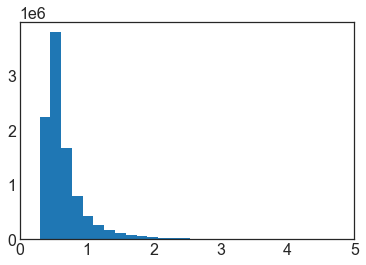

In [26]:
plt.hist(dC_all.flatten(), bins=200)
plt.xlim((0,5))
print(dC_all.flatten().max())
print(dC_all.flatten().min())

4.396402766716858
2.3111968011061175e-07


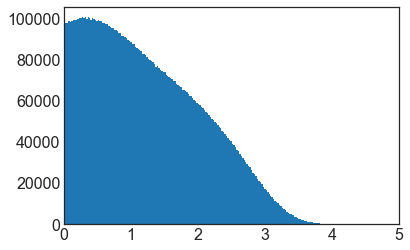

In [29]:
stn = np.abs(C_all.flatten()/dC_all.flatten())
plt.hist(stn, bins=200)
plt.xlim((0,5))
print(stn.max())
print(stn.flatten().min())